In [1]:
import akshare as ak
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.pyplot import MultipleLocator
import pymysql
from sqlalchemy import create_engine
from matplotlib.ticker import MultipleLocator, FormatStrFormatter
import matplotlib.ticker as mticker
from sklearn.linear_model import LinearRegression
import numpy as np
from scipy import stats
from operator import add
import pylab as mpl
import matplotlib
import warnings

#忽略警告
warnings.filterwarnings("ignore")

#如果有人想调整可滚动输出的高度而不是删除滚动功能：
from IPython.core.display import display, HTML
display(HTML("<style>div.output_scroll { height: 40em; }</style>"))

# 设置中文显示字体，因为matplotlib默认不支持中文
mpl.rcParams['font.sans-serif'] = ['FangSong']  # 指定默认字体为仿宋

# 用来正常显示负号及# 用来正常显示中文标签
plt.rcParams['axes.unicode_minus']=False
plt.rcParams['font.sans-serif'] = ['SimHei']
#DF中文字段对齐
pd.set_option('display.unicode.ambiguous_as_wide', True)
pd.set_option('display.unicode.east_asian_width', True)

#先从AKSHARE取得集思录的所有转债数据
jsl_all_df=ak.bond_cb_index_jsl()
#然后用LOC筛选指定日期后面的数据，避免数据时段太长。
start_day='2021-10-01'
end_day='2023-09-30'
bond_cb_index_jsl_df=jsl_all_df.loc[(jsl_all_df['price_dt']>=start_day)&(jsl_all_df['price_dt']<=end_day)]
print(bond_cb_index_jsl_df.columns)
print(bond_cb_index_jsl_df.tail(5))
#定义参数意义字典，以显示中文字段名字。
bondpara={'avg_dblow':'平均双低','mid_price':'中位数价格（元）','mid_premium_rt':'中位数溢价率','avg_ytm_rt':'平均收益率',
          'price_dt':'日期','price':'指数',
          'amount':'剩余规模','volume':'成交额（亿元）','count':'数量','increase_val':'涨跌',
          'increase_rt':'涨幅','avg_price':'平均价格（元）',
          'mid_convert_value':'中位数转股价值','avg_premium_rt':'平均溢价率','turnover_rt':'换手率',
          'price_90':'价格<90','price_90_100':'90<价格<100','price_100_110':'100<价格<110','price_110_120':'110<价格<120',
          'price_120_130':'120<价格<130',
          'price_130':'价格>130','idx_price':'沪深 300 收盘价'}

s_count=bond_cb_index_jsl_df['count']/100      #转债数量，除以100是为了后面计算比例时，按照百分几，取几，数值不会太小
s_count2=sum(bond_cb_index_jsl_df['price_dt'].value_counts())      #日期数量，作为所有中位数计数的总数。
#print(s_count2)

#将DF保存为excel文件
bond_cb_index_jsl_df.to_excel("./out/bond_cb_index_jsl_df.xlsx", index=False)

Index(['price_dt', 'price', 'amount', 'volume', 'count', 'increase_val',
       'increase_rt', 'avg_price', 'mid_price', 'mid_convert_value',
       'avg_dblow', 'avg_premium_rt', 'mid_premium_rt', 'avg_ytm_rt',
       'turnover_rt', 'price_90', 'price_90_100', 'price_100_110',
       'price_110_120', 'price_120_130', 'price_130', 'increase_rt_90',
       'increase_rt_90_100', 'increase_rt_100_110', 'increase_rt_110_120',
       'increase_rt_120_130', 'increase_rt_130', 'idx_price',
       'idx_increase_rt'],
      dtype='object')
        price_dt     price   amount  volume  count  increase_val  increase_rt  \
1378  2023-09-01  2040.863  8673.66  466.68    530         3.606         0.18   
1379  2023-09-04  2054.823  8676.78  435.81    531        13.960         0.68   
1380  2023-09-05  2051.823  8668.21  503.06    531        -3.000        -0.15   
1381  2023-09-06  2051.802  8656.97  475.51    532        -0.021        -0.00   
1382  2023-09-07  2018.625  8654.24  595.17    533       -

In [2]:
#为绘制中位数价格曲线走势图中的四分位线，先做数据切分的准备
#使用quantile 找出四分位处的数值，
cut_list = [0, 0.25, 0.5, 0.75, 1]
cut_income_mid_price = bond_cb_index_jsl_df['mid_price'].quantile(q=cut_list)
#print(cut_income_mid_price)
#设置四条横线的颜色，为最后画四分位线作好数据准备。
colors_4 = ['red', 'green', 'blue', 'yellow']
#为绘制中位数溢价率曲线走势图中的四分位线，先做数据切分的准备
cut_income_mid_premium_rt = bond_cb_index_jsl_df['mid_premium_rt'].quantile(q=cut_list)
#print(cut_income_mid_premium_rt)

#计算可转债等权指数的标准差
std_price = bond_cb_index_jsl_df['price'].std()
print(std_price)
#计算可转债等权指数的平均值
mean_price = bond_cb_index_jsl_df['price'].mean()
print(mean_price)
#计算标准差与平均值的百分比
std_mean=std_price/mean_price
print(std_mean)
#先将dataframe转换成Serices，才能求移动平均
#print(bond_cb_index_jsl_df['price'])
series_price=pd.Series(bond_cb_index_jsl_df['price'])
#print(series_price)
#设置窗口的天数大小
window_d=20
#求可转债等权指数的移动平均值
moving_avg=series_price.rolling(window_d).mean()
#求可转债等权指数的移动标准差
moving_std=series_price.rolling(window_d).std()
#print(moving_avg)
#先复制bond_cb_index_jsl_df
df_jsl=bond_cb_index_jsl_df.copy(deep=True)
#print(df_moving)
#把移动平均值与移动标准差分别添加到dataframe作为列
df_moving_avg=pd.DataFrame({"moving_avg":moving_avg})
df_moving_std=pd.DataFrame({"moving_std":moving_std})
df_jsl_moving=pd.concat([df_jsl,df_moving_avg],axis=1)
df_jsl_moving=pd.concat([df_jsl_moving,df_moving_std],axis=1)
#分别添加两列，一列是加上标准差，另一列是减去标准差
df_jsl_moving["moving_avg_add_std"]=df_jsl_moving["moving_avg"]+df_jsl_moving["moving_std"]
df_jsl_moving["moving_avg_sub_std"]=df_jsl_moving["moving_avg"]-df_jsl_moving["moving_std"]
#分别添加两列，一列是加上2倍标准差，另一列是减去2倍标准差
df_jsl_moving["moving_avg_add_2std"]=df_jsl_moving["moving_avg"]+df_jsl_moving["moving_std"]*2
df_jsl_moving["moving_avg_sub_2std"]=df_jsl_moving["moving_avg"]-df_jsl_moving["moving_std"]*2
print(df_jsl_moving)

#均线加上标准差(原来的作图系列，不再使用。)
#moving_avg_add_std=pd.Series([i+std_price for i in moving_avg])
#print(moving_avg_add_std)
#均线减去标准差(原来的作图系列，不再使用。)
#moving_avg_sub_std=pd.Series([i-std_price for i in moving_avg])
#print(moving_avg_sub_std)

72.64985235048796
2013.1888531914892
0.03608695340991822
        price_dt     price   amount  volume  count  increase_val  increase_rt  \
913   2021-10-08  1845.301  6169.37  572.64    374         8.047         0.44   
914   2021-10-11  1842.422  6165.45  616.30    374        -2.879        -0.16   
915   2021-10-12  1811.709  6161.79  662.77    373       -30.713        -1.67   
916   2021-10-13  1807.977  6155.42  578.17    373        -3.732        -0.21   
917   2021-10-14  1819.530  6152.99  617.58    373        11.553         0.64   
...          ...       ...      ...     ...    ...           ...          ...   
1378  2023-09-01  2040.863  8673.66  466.68    530         3.606         0.18   
1379  2023-09-04  2054.823  8676.78  435.81    531        13.960         0.68   
1380  2023-09-05  2051.823  8668.21  503.06    531        -3.000        -0.15   
1381  2023-09-06  2051.802  8656.97  475.51    532        -0.021        -0.00   
1382  2023-09-07  2018.625  8654.24  595.17    533  

In [3]:
#把bond_cb_index_jsl_df最后一行的数据转换成列表，用于绘制饼图
list_pie= bond_cb_index_jsl_df[['price_90_100','price_100_110','price_110_120','price_120_130','price_130']].tail(1).values.tolist()
#list_pie是2维的（2D)，因此后面画饼图的时候，必须用list_pie[0]转换成一维（1D)
print(list_pie[0])
#取得列名，作为饼图的标签。
list_pie_title=bond_cb_index_jsl_df[['price_90_100','price_100_110','price_110_120','price_120_130','price_130']].columns.tolist()
print(list_pie_title)

[6, 66, 171, 150, 140]
['price_90_100', 'price_100_110', 'price_110_120', 'price_120_130', 'price_130']


In [4]:
#通过中位数的最大值及最小值，以步长为-1构造中位数价格列表
med_high=[]  #中位数价格_高位的区间列表
med_low=[]   #中位数价格_低位的区间列表，在本程序中没有实际应用。
med_max=int(bond_cb_index_jsl_df['mid_price'].max(0))
med_min=int(bond_cb_index_jsl_df['mid_price'].min(0))
#print(str(med_max))
#print(str(med_min))
med_cut=int((med_max-med_min)/10)
#print(str(med_cut))
for i in range(med_max+1,med_min-1,-1):
     med_high.append(i)
print(med_high)
for i in range(med_min-1,med_max+1,1):
     med_low.append(i)   #中位数价格_低位的区间列表，在本程序中没有实际应用。
print(med_low)

[132, 131, 130, 129, 128, 127, 126, 125, 124, 123, 122, 121, 120, 119, 118, 117, 116, 115, 114, 113, 112, 111]
[110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131]


In [5]:
med_high_dict={}  #高值字典：中位数价格列表，当期所占的天数，当期所占的比例
med_high_dict_plt={}  #高值字典用于画图：中位数价格列表，当期所占的天数，当期所占的比例
for i in med_high:
    #大于当前i值的中位数价格的日期个数，采用日期，不采用中位数价格，因为日期不会重复。
    i_days=bond_cb_index_jsl_df.loc[bond_cb_index_jsl_df['mid_price']>=i]['price_dt'].value_counts()
    #将日期个数汇总
    total_days=sum(i_days)
    #计算当前i值的总（日期）个数在全部中位数中的百分比。
    i_percent=round(total_days/s_count2*100,2)
    #print("                   ")
    #print("================="+str(i)+"_days as flows: =============")
    #print(i_days)
    #print("//////总体信息：  "+str(i)+"_days:"+str(total_days)+" 百分比： "+str(i_percent)+"%////////")
    #构造字典
    med_high_dict[">"+str(i)+":"]=str(total_days)+" "+'{:>05}'.format(str('{:.2f}'.format(i_percent)))+"%"
    #构造用于画图的字典
    med_high_dict_plt[str(i)]=str(i_percent)
print(med_high_dict)
df_med_high_dict = pd.DataFrame.from_dict(med_high_dict, orient='index', columns=['value']) #将字典转换成dataframe打印
print(df_med_high_dict)


{'>132:': '0 00.00%', '>131:': '3 00.64%', '>130:': '15 03.19%', '>129:': '22 04.68%', '>128:': '36 07.66%', '>127:': '58 12.34%', '>126:': '81 17.23%', '>125:': '101 21.49%', '>124:': '144 30.64%', '>123:': '200 42.55%', '>122:': '256 54.47%', '>121:': '295 62.77%', '>120:': '337 71.70%', '>119:': '395 84.04%', '>118:': '425 90.43%', '>117:': '446 94.89%', '>116:': '459 97.66%', '>115:': '465 98.94%', '>114:': '466 99.15%', '>113:': '466 99.15%', '>112:': '469 99.79%', '>111:': '470 100.00%'}
             value
>132:     0 00.00%
>131:     3 00.64%
>130:    15 03.19%
>129:    22 04.68%
>128:    36 07.66%
>127:    58 12.34%
>126:    81 17.23%
>125:   101 21.49%
>124:   144 30.64%
>123:   200 42.55%
>122:   256 54.47%
>121:   295 62.77%
>120:   337 71.70%
>119:   395 84.04%
>118:   425 90.43%
>117:   446 94.89%
>116:   459 97.66%
>115:   465 98.94%
>114:   466 99.15%
>113:   466 99.15%
>112:   469 99.79%
>111:  470 100.00%


In [6]:
#为后面可能的散点图作数据集准备，实际没有使用。
#将高值中位数（键）及百分比（值）分别转换成列表
labels_sct = list(med_high_dict_plt.keys())
values_sct = list(med_high_dict_plt.values())

#将列表元素由字符转换成浮点数据
labels_sct= [float(x) for x in labels_sct]
values_sct = [float(x) for x in values_sct]
print(labels_sct)
print(values_sct)

[132.0, 131.0, 130.0, 129.0, 128.0, 127.0, 126.0, 125.0, 124.0, 123.0, 122.0, 121.0, 120.0, 119.0, 118.0, 117.0, 116.0, 115.0, 114.0, 113.0, 112.0, 111.0]
[0.0, 0.64, 3.19, 4.68, 7.66, 12.34, 17.23, 21.49, 30.64, 42.55, 54.47, 62.77, 71.7, 84.04, 90.43, 94.89, 97.66, 98.94, 99.15, 99.15, 99.79, 100.0]


In [7]:
#下面通过pandas的cagegories类型的cut方法对中位数的dataframe，根据设置的标签，进行自动分类
#第一步：设置分类区间
mid_bins=[60,70,80,90,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,
          116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135]

In [8]:
#第二步：设置分类标签
mid_labels=["060-070","070-080","080-090","090-100",
            "100-101","101-102","102-103","103-104","104-105",
            "105-106","106-107","107-108","108-109","109-110",
            "110-111","111-112","112-113","113-114","114-115",
            "115-116","116-117","117-118","118-119","119-120","120-121","121-122",
            "122-123","123-124","124-125","125-126","126-127","127-128","128-129","129-130",
            "130-131","131-132","132-133","133-134","134-135"]

In [9]:
#运用cut方法，按照所设分类区间，自动确定各分区的值属于哪个分类标签
a,b = pd.cut(x=bond_cb_index_jsl_df['mid_price'],bins=mid_bins,right=True,retbins=True,labels=mid_labels)

In [10]:
#打印前面10个记录
print(a.head(10))

913    119-120
914    119-120
915    117-118
916    117-118
917    117-118
918    117-118
919    118-119
920    118-119
921    119-120
922    118-119
Name: mid_price, dtype: category
Categories (39, object): ['060-070' < '070-080' < '080-090' < '090-100' ... '131-132' < '132-133' < '133-134' < '134-135']


In [11]:
#打印后面10个记录
print(a.tail(10))

1373    119-120
1374    119-120
1375    121-122
1376    121-122
1377    121-122
1378    122-123
1379    123-124
1380    123-124
1381    123-124
1382    121-122
Name: mid_price, dtype: category
Categories (39, object): ['060-070' < '070-080' < '080-090' < '090-100' ... '131-132' < '132-133' < '133-134' < '134-135']


In [12]:
#t=[1,2,2,3,3,3,3,3,'a','a','a']

In [13]:
#设置t等于a：a即是已经设置分类标签的数据系列，类型是cagegory类型
t=a

In [14]:
#设置直方图字典
hist={}

In [15]:
#对同一标签的字典元素进行加和统计，即是同一标签的个数累计，并构造字典，这样即是分别统计出了各个同一区间的总个数，用于绘制直方图
for x in t:
    hist[x]=hist.get(x,0)+1
print(hist)

{'119-120': 58, '117-118': 21, '118-119': 30, '120-121': 42, '121-122': 40, '122-123': 54, '123-124': 57, '124-125': 43, '125-126': 20, '126-127': 23, '127-128': 22, '128-129': 13, '130-131': 12, '131-132': 3, '129-130': 7, '116-117': 14, '115-116': 6, '112-113': 3, '111-112': 1, '114-115': 1}


In [16]:
# 使用sum()函数求和
sum_hist = sum(value for value in hist.values() if isinstance(value, int))
print(sum_hist)  

470


In [17]:
#数据字典排序
hist = dict(sorted(hist.items()))
print(hist)

{'111-112': 1, '112-113': 3, '114-115': 1, '115-116': 6, '116-117': 14, '117-118': 21, '118-119': 30, '119-120': 58, '120-121': 42, '121-122': 40, '122-123': 54, '123-124': 57, '124-125': 43, '125-126': 20, '126-127': 23, '127-128': 22, '128-129': 13, '129-130': 7, '130-131': 12, '131-132': 3}


In [18]:
#数据字典hist{}来自于前面生成的各同一分类区间标签进行加和所生成的字典，并将键与值分别转换成列表。
x_hist = list(hist.keys())
y_hist = list(hist.values())
print(x_hist)
print(y_hist)

['111-112', '112-113', '114-115', '115-116', '116-117', '117-118', '118-119', '119-120', '120-121', '121-122', '122-123', '123-124', '124-125', '125-126', '126-127', '127-128', '128-129', '129-130', '130-131', '131-132']
[1, 3, 1, 6, 14, 21, 30, 58, 42, 40, 54, 57, 43, 20, 23, 22, 13, 7, 12, 3]


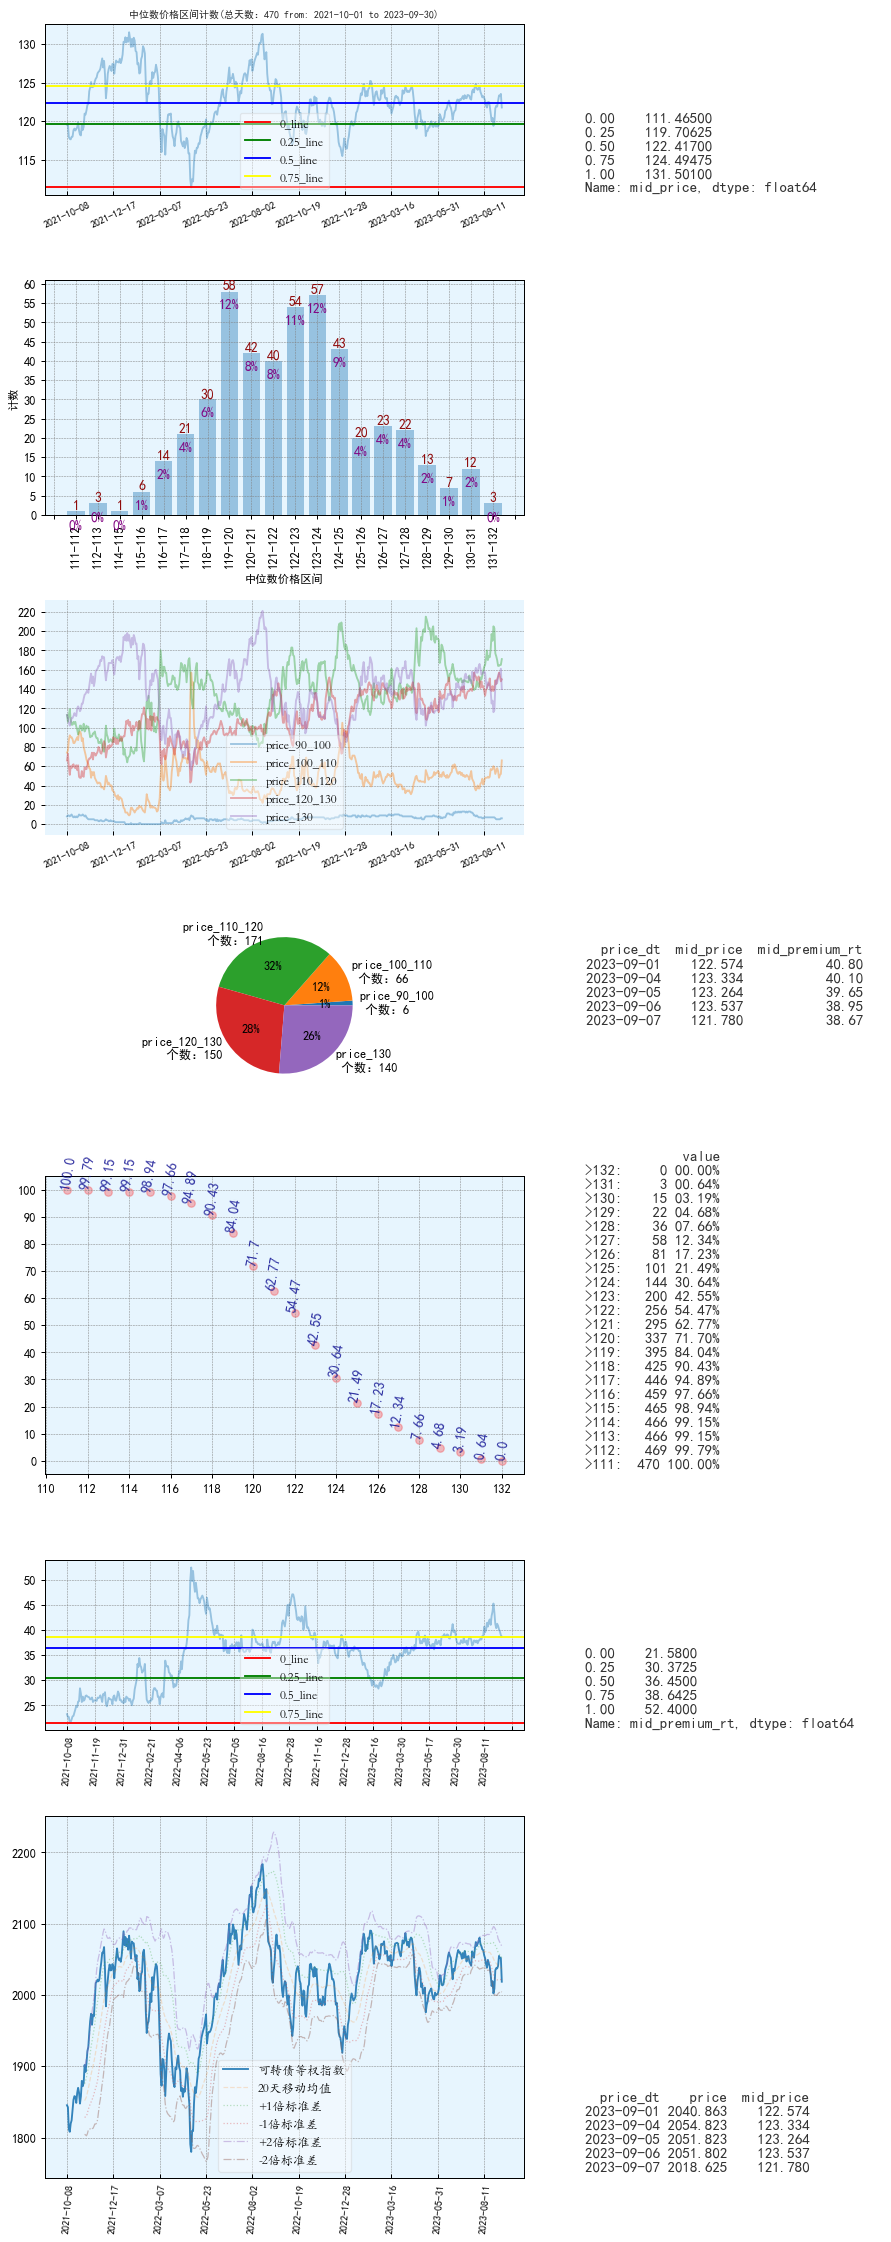

In [19]:
#直方图的数据集
labels = x_hist
values = y_hist

#设置各个子图的位置及所占的格子位置
fig = plt.subplots(figsize=(12,32), dpi=90) #修改图象尺寸，要同时修改dpi的大小，才有作用。
grid = plt.GridSpec(35,5, wspace=0.5, hspace=0.5)
ax1_midprice = plt.subplot(grid[0:3,0:3])     #中位数曲线走势图
ax2 = plt.subplot(grid[18:23,3:4])   #不画图，仅显示文本(高位价格区间)
ax3 = plt.subplot(grid[13:16,3:5])   #不画图，仅显示文本（中位数价格后三条记录）
ax4_midbar = plt.subplot(grid[4:8,0:3])     #直方图
ax5_cutprice = plt.subplot(grid[9:13,0:3])    #各区间价格个数曲线走势图
ax6_cutpie = plt.subplot(grid[14:17,0:3])   #各区间价格个数饼图比例图
ax7_midscatter = plt.subplot(grid[18:23,0:3])   #高位价格区间散点图
ax8 = plt.subplot(grid[0:3,3:4])   #不画图，中位数价格走势图的四分位线的值
ax9_midprem = plt.subplot(grid[24:27,0:3])   #中位数溢价率走势图
ax10 = plt.subplot(grid[24:27,3:4])   #不画图，中位数溢价率走势图的四分位线的值
ax11_jslprice = plt.subplot(grid[28:34,0:3])   #可转债等权指数走势图
ax12 = plt.subplot(grid[28:34,3:4])   #不画图，可转债等权指数的值

#绘制中位数价格曲线走势图
ax1_midprice.plot(bond_cb_index_jsl_df['price_dt'],bond_cb_index_jsl_df['mid_price'],alpha=0.4)
#绘制中位数价格曲线走势图中的四分位线
for i in range(0, 4):
    ax1_midprice.axhline(cut_income_mid_price[cut_list[i]], color=colors_4[i], label=str(cut_list[i])+'_line')
#绘制中位数价格区间直方图
ax4_midbar.bar(labels, values,alpha=0.4) 
#绘制分价格各条曲线走势图
ax5_cutprice.plot(bond_cb_index_jsl_df['price_dt'],bond_cb_index_jsl_df['price_90_100'],alpha=0.4,label='price_90_100')
ax5_cutprice.plot(bond_cb_index_jsl_df['price_dt'],bond_cb_index_jsl_df['price_100_110'],alpha=0.4,label='price_100_110')
ax5_cutprice.plot(bond_cb_index_jsl_df['price_dt'],bond_cb_index_jsl_df['price_110_120'],alpha=0.4,label='price_110_120')
ax5_cutprice.plot(bond_cb_index_jsl_df['price_dt'],bond_cb_index_jsl_df['price_120_130'],alpha=0.4,label='price_120_130')
ax5_cutprice.plot(bond_cb_index_jsl_df['price_dt'],bond_cb_index_jsl_df['price_130'],alpha=0.4,label='price_130')
#绘制分价格饼图
#list_pie是2维的（2D)，因此这里画饼图的时候，必须用list_pie[0]转换成一维（1D)
ax6_cutpie.pie(list_pie[0], labels=list(map(add,list_pie_title,["\n 个数："+str(i) for i in list_pie[0]])),autopct='%.0f%%')
#绘制散点图
ax7_midscatter.scatter(labels_sct,values_sct,color="red",label="天数占比",alpha=0.25,marker = 'o')
#绘制中位数溢价率曲线走势图
ax9_midprem.plot(bond_cb_index_jsl_df['price_dt'],bond_cb_index_jsl_df['mid_premium_rt'],alpha=0.4)
#绘制中位数溢价率曲线走势图中的四分位线
for i in range(0, 4):
    ax9_midprem.axhline(cut_income_mid_premium_rt[cut_list[i]], color=colors_4[i], label=str(cut_list[i])+'_line')
#绘制可转债等权指数曲线走势图
#之所以需要逗号是因为plt.plot()返回一个行对象的元组，无论从命令实际创建了多少个。
#如果没有逗号，“plot1”和“plot2”是元组而不是行对象，这使得后来对plt.legend()的调用失败。
L1,=ax11_jslprice.plot(df_jsl_moving['price_dt'],df_jsl_moving['price'],alpha=0.9)  #可转债等权指数
L2,=ax11_jslprice.plot(df_jsl_moving['price_dt'],df_jsl_moving['moving_avg'],'--',alpha=0.2,linewidth=1.0)  #移动均值
L3,=ax11_jslprice.plot(df_jsl_moving['price_dt'],df_jsl_moving['moving_avg_add_std'],':',alpha=0.3,linewidth=1.0)  #加上标准差
L4,=ax11_jslprice.plot(df_jsl_moving['price_dt'],df_jsl_moving['moving_avg_sub_std'],':',alpha=0.3,linewidth=1.0)  #减去标准差
L5,=ax11_jslprice.plot(df_jsl_moving['price_dt'],df_jsl_moving['moving_avg_add_2std'],'-.',alpha=0.4,linewidth=1.0)  #加上2倍标准差
L6,=ax11_jslprice.plot(df_jsl_moving['price_dt'],df_jsl_moving['moving_avg_sub_2std'],'-.',alpha=0.4,linewidth=1.0)  #减去2倍标准差

#设置子图的标题
ax1_midprice.set_title('中位数价格区间计数'+"(总天数："+str(sum_hist)+" from: "+start_day+" to "+end_day+")", 
              fontsize=8, color='black',alpha=0.85, ha='center',)

#设置各个子图的X轴、Y轴的刻度
ax2.set_xticks([])  # 不显示X轴、Y轴
ax2.set_yticks([])  # 不显示X轴、Y轴
ax3.set_xticks([])  # 不显示X轴、Y轴
ax3.set_yticks([])  # 不显示X轴、Y轴
ax4_midbar.set_xticks(x_hist)  # 确定xticks的个数，一定要设置，X轴、Y轴的显示才正确
ax4_midbar.set_yticks(y_hist)  # 确定xticks的个数，一定要设置，X轴、Y轴的显示才正确
ax8.set_xticks([])  # 不显示X轴、Y轴
ax8.set_yticks([])  # 不显示X轴、Y轴
ax10.set_xticks([])  # 不显示X轴、Y轴
ax10.set_yticks([])  # 不显示X轴、Y轴
ax12.set_xticks([])  # 不显示X轴、Y轴
ax12.set_yticks([])  # 不显示X轴、Y轴

#X、Y轴的刻度间隔
xm_mid = MultipleLocator(50)    # x轴每50一个刻度
ym_mid = MultipleLocator(5)    # y轴每50一个刻度
ax1_midprice.xaxis.set_major_locator(xm_mid)
ax1_midprice.yaxis.set_major_locator(ym_mid)

xm_hist = MultipleLocator(1)    # x轴每50一个刻度
ym_hist = MultipleLocator(5)    # y轴每50一个刻度
ax4_midbar.xaxis.set_major_locator(xm_hist)
ax4_midbar.yaxis.set_major_locator(ym_hist)

xm_pri = MultipleLocator(50)    # x轴每50一个刻度
ym_pri = MultipleLocator(20)    # y轴每50一个刻度
ax5_cutprice.xaxis.set_major_locator(xm_pri)
ax5_cutprice.yaxis.set_major_locator(ym_pri)

xm_sct = MultipleLocator(2)    # x轴每50一个刻度
ym_sct = MultipleLocator(10)    # y轴每50一个刻度
ax7_midscatter.xaxis.set_major_locator(xm_sct)
ax7_midscatter.yaxis.set_major_locator(ym_sct)

xm_prem = MultipleLocator(30)    # x轴每50一个刻度
ym_prem = MultipleLocator(5)    # y轴每50一个刻度
ax9_midprem.xaxis.set_major_locator(xm_prem)
ax9_midprem.yaxis.set_major_locator(ym_prem)

xm_pri = MultipleLocator(50)    # x轴每50一个刻度
ym_pri = MultipleLocator(100)    # y轴每50一个刻度
ax11_jslprice.xaxis.set_major_locator(xm_pri)
ax11_jslprice.yaxis.set_major_locator(ym_pri)

#设置各个子图的边框是否显示：不显示边框,此时只会取消边框，不会取消坐标轴标签
[ax2.spines[loc_axis].set_visible(False) for loc_axis in ['top','right','bottom','left']]
[ax3.spines[loc_axis].set_visible(False) for loc_axis in ['top','right','bottom','left']]
[ax5_cutprice.spines[loc_axis].set_visible(False) for loc_axis in ['top','right','bottom','left']]
[ax8.spines[loc_axis].set_visible(False) for loc_axis in ['top','right','bottom','left']]
[ax10.spines[loc_axis].set_visible(False) for loc_axis in ['top','right','bottom','left']]
[ax12.spines[loc_axis].set_visible(False) for loc_axis in ['top','right','bottom','left']]

#设置各个子图的网格及背景等风格
ax1_midprice.grid(True,linestyle="--",color="gray",linewidth="0.4",axis="both")
ax1_midprice.patch.set_facecolor("lightskyblue") # 设置 ax1 区域背景颜色
ax1_midprice.patch.set_alpha(0.2) # 设置 ax1 区域背景颜色透明度

ax4_midbar.grid(True,linestyle="--",color="gray",linewidth="0.4",axis="both")
ax4_midbar.patch.set_facecolor("lightskyblue") # 设置 ax1 区域背景颜色
ax4_midbar.patch.set_alpha(0.2) # 设置 ax1 区域背景颜色透明度

ax5_cutprice.grid(True,linestyle="--",color="gray",linewidth="0.4",axis="both")
ax5_cutprice.patch.set_facecolor("lightskyblue") # 设置 ax1 区域背景颜色
ax5_cutprice.patch.set_alpha(0.2) # 设置 ax1 区域背景颜色透明度

ax7_midscatter.grid(True,linestyle="--",color="gray",linewidth="0.4",axis="both")
ax7_midscatter.patch.set_facecolor("lightskyblue") # 设置 ax1 区域背景颜色
ax7_midscatter.patch.set_alpha(0.2) # 设置 ax1 区域背景颜色透明度

ax9_midprem.grid(True,linestyle="--",color="gray",linewidth="0.4",axis="both")
ax9_midprem.patch.set_facecolor("lightskyblue") # 设置 ax1 区域背景颜色
ax9_midprem.patch.set_alpha(0.2) # 设置 ax1 区域背景颜色透明度

ax11_jslprice.grid(True,linestyle="--",color="gray",linewidth="0.4",axis="both")
ax11_jslprice.patch.set_facecolor("lightskyblue") # 设置 ax1 区域背景颜色
ax11_jslprice.patch.set_alpha(0.2) # 设置 ax1 区域背景颜色透明度

#设置各个子图的X轴、Y轴的标签的字体大小、旋转、透明度等显示形式
#旋转特定坐标区的 x 轴刻度标签
ax1_midprice.tick_params(axis='x',tickdir='in',labelsize=8,rotation=25)
#ax4的X轴标签旋转90度
for tick in ax4_midbar.get_xticklabels():
    tick.set_rotation(90)
ax4_midbar.set_xlabel('中位数价格区间', fontsize=9)
ax4_midbar.set_ylabel('计数', fontsize=9)
ax5_cutprice.tick_params(axis='x',tickdir='in',labelsize=8,rotation=25)
ax9_midprem.tick_params(axis='x',tickdir='in',labelsize=8,rotation=85)
ax11_jslprice.tick_params(axis='x',tickdir='in',labelsize=8,rotation=85)

#设置右侧各个子图显示的文本内容
ax2.text(0.01,0.02,str(df_med_high_dict[['value']].head(35).to_string(index=True)),
        color='black',fontsize=12,alpha=0.8,rotation=0)
ax3.text(0.01,0.02,str(bond_cb_index_jsl_df[['price_dt','mid_price','mid_premium_rt']].tail(5).to_string(index=False)),
        color='black',fontsize=12,alpha=0.8,rotation=0)
ax8.text(0.01,0.02,str(cut_income_mid_price),
        color='black',fontsize=12,alpha=0.8,rotation=0)
ax10.text(0.01,0.02,str(cut_income_mid_premium_rt),
        color='black',fontsize=12,alpha=0.8,rotation=0)
ax12.text(0.01,0.02,str(bond_cb_index_jsl_df[['price_dt','price','mid_price']].tail(5).to_string(index=False)),
        color='black',fontsize=12,alpha=0.8,rotation=0)

#直方图标注数据点
for a, b in zip(x_hist, y_hist):
    ax4_midbar.text(a, b,str(b), ha='center', va='bottom', fontsize=11, color='darkred',alpha=0.95,rotation=0)
    ax4_midbar.text(a, b-5,str(int(b/sum_hist*100))+"%", ha='center', va='bottom', fontsize=11, color='purple',alpha=0.95,rotation=0)
#散点图标注数据点
for a, b in zip(labels_sct, values_sct):
    ax7_midscatter.text(a, b,str(b), ha='center', va='bottom', fontsize=11, color='darkblue',alpha=0.8,rotation=80)

# 添加图例
ax1_midprice.legend(loc='lower center',framealpha=0.4,prop='STKaiti',fontsize=5)
ax5_cutprice.legend(loc='lower center',framealpha=0.4,prop='STKaiti',fontsize=5)
ax9_midprem.legend(loc='lower center',framealpha=0.4,prop='STKaiti',fontsize=5)
ax11_jslprice.legend([L1, L2, L3, L4, L5, L6],['可转债等权指数', str(window_d)+'天移动均值',
                                               '+1倍标准差', '-1倍标准差', '+2倍标准差', '-2倍标准差'],
                     loc = 'lower center',framealpha=0.4,prop='STKaiti',fontsize=5)
#plt.tight_layout()
plt.savefig("./out/mid_price_analysis.png",dpi=300)
plt.show()
